In [1]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel


import time
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
np.random.seed(0)
df = pd.read_csv("../../Data/dataset2/train.csv")

df.dropna(inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
drop_indices = np.random.choice(np.arange(0, df.shape[0], 1), 350, replace=False)
df.drop(drop_indices, inplace=True)
X = df.drop(columns=['price_range'])
y = df[['price_range']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
df[['price_range']].value_counts()

price_range
1              419
0              417
2              416
3              398
dtype: int64

In [75]:
# No need to scale now - as the trees are not effected by scaling
# preventing information about the distribution of the test set leaking into your model
# standard_scaler = MinMaxScaler()
# x_train_scaled = standard_scaler.fit_transform(x_train)
# x_test_scaled = standard_scaler.fit_transform(x_test)
# y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
# y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')
x_train_scaled = x_train
x_test_scaled = x_test
y_train_scaled = y_train
y_test_scaled = y_test

In [103]:
clf = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(max_depth=1, random_state=0))
start_time = time.time()
clf.fit(x_train_scaled, y_train_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred)}")
print(classification_report(y_test_scaled, y_pred))

KNN Normal Model: Fit Time: 0.10234737396240234
KNN Normal Model: Fit Time: 0.008303165435791016
Score of Model Tree are (Mean Accuracy of test and train data): 0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.48      0.61        88
           1       0.54      0.81      0.65        79
           2       0.70      0.79      0.75        87
           3       0.85      0.72      0.78        76

    accuracy                           0.70       330
   macro avg       0.74      0.70      0.70       330
weighted avg       0.74      0.70      0.70       330



In [111]:
d = df.shape[1]
depth_range = np.arange(0, 200, 5)
param = "n_estimators"
classifier = "AdaBoost"
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name=param, param_range=depth_range, cv=5, n_jobs=-1)

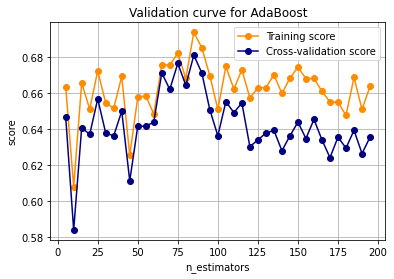

In [113]:
import os
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = depth_range
plt.figure()
# plt.xticks(np.arange(0, len(depth_range), 5))
plt.plot(depth_range_list, mean_train_scores, 'o-', color="darkorange", label='Training score')
# plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', color="navy", label='Cross-validation score')
# plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/ada_validation_curve_price.png')
plt.show()

In [108]:
### PIPELINES ###
# Data scaled in pipeline already
pipeline = make_pipeline(SelectFromModel(RandomForestClassifier(random_state=0)), AdaBoostClassifier(random_state=0))
pipeline.fit(x_train_scaled, y_train_scaled)
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline = pipeline.predict(x_test_scaled)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline)}")
print(classification_report(y_test_scaled, y_pred_pipeline))

MLP Pipeline Model: Fit Time: 622.5928978919983
MLP Pipeline Model: Predict Time: 0.012609243392944336
Score of Model Tree are (Mean Accuracy of test and train data): 0.7
              precision    recall  f1-score   support

           0       0.82      0.51      0.63        88
           1       0.55      0.80      0.65        79
           2       0.83      0.60      0.69        87
           3       0.72      0.93      0.82        76

    accuracy                           0.70       330
   macro avg       0.73      0.71      0.70       330
weighted avg       0.73      0.70      0.69       330



In [45]:
### TUNING ####
d = x_train.shape[1]
param = {'adaboostclassifier__learning_rate': np.arange(0.1, 1.0, 0.1),
         'adaboostclassifier__algorithm': ['SAMME'],
         'adaboostclassifier__n_estimators': np.arange(1, 500),
         'adaboostclassifier__base_estimator': [DecisionTreeClassifier(random_state=0, max_depth=2)]
        }
clf_cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True, verbose=1)
start_time = time.time()
clf_cv = clf_cv.fit(x_train_scaled, np.ravel(y_train_scaled))
print(f"MLP CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test_scaled)
print(f"MLP CV Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline_cv)}")
print(classification_report(np.ravel(y_test_scaled), y_pred_pipeline_cv))

Fitting 5 folds for each of 4491 candidates, totalling 22455 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 3858 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 4808 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 5858 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7008 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8258 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9608 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 11058 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 12608 tasks    

MLP CV Model: Fit Time: 260.83070969581604
MLP CV Model: Predict Time: 0.017354726791381836
Score of Model Tree are (Mean Accuracy of test and train data): 0.8848484848484849
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        88
           1       0.82      0.89      0.85        79
           2       0.84      0.86      0.85        87
           3       0.92      0.89      0.91        76

    accuracy                           0.88       330
   macro avg       0.89      0.89      0.89       330
weighted avg       0.89      0.88      0.89       330



In [46]:
clf_cv.best_params_

{'adaboostclassifier__algorithm': 'SAMME',
 'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=2, random_state=0),
 'adaboostclassifier__learning_rate': 0.9,
 'adaboostclassifier__n_estimators': 148}

In [47]:
### Learning Curve ###
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0, max_depth=2), n_estimators=148, learning_rate=0.9, algorithm="SAMME")
_, train_scores, test_scores = learning_curve(clf_new, x_train_scaled, y_train_scaled, train_sizes=train_sizes, cv=5)

ValueError: x and y must have same first dimension, but have shapes (9,) and (40,)

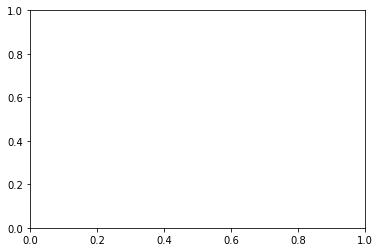

In [114]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', color="darkorange", label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', color="navy", label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for Boosting')
plt.xlabel('Fraction of training examples')

plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/ada_learning_curve_price.png')
plt.show()

In [69]:
lw = 2
params = np.arange(1, 400, 5)
clf_score_list = []
fit_time_list = []
predict_time_list = []
main_start_time = time.time()
for i in params:
    print(f"Iteration: {i}")
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0, max_depth=1), n_estimators=i, learning_rate=0.9)
    start_time = time.time()
    clf.fit(x_train_scaled, y_train_scaled)
    clf_score_list.append(clf.score(x_test_scaled, y_test_scaled))
    
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
    
print(f"Entire cell took {time.time() - main_start_time}")

Iteration: 1
Iteration: 6
Iteration: 11
Iteration: 16
Iteration: 21
Iteration: 26
Iteration: 31
Iteration: 36
Iteration: 41
Iteration: 46
Iteration: 51
Iteration: 56
Iteration: 61
Iteration: 66
Iteration: 71
Iteration: 76
Iteration: 81
Iteration: 86
Iteration: 91
Iteration: 96
Iteration: 101
Iteration: 106
Iteration: 111
Iteration: 116
Iteration: 121
Iteration: 126
Iteration: 131
Iteration: 136
Iteration: 141
Iteration: 146
Iteration: 151
Iteration: 156
Iteration: 161
Iteration: 166
Iteration: 171
Iteration: 176
Iteration: 181
Iteration: 186
Iteration: 191
Iteration: 196
Iteration: 201
Iteration: 206
Iteration: 211
Iteration: 216
Iteration: 221
Iteration: 226
Iteration: 231
Iteration: 236
Iteration: 241
Iteration: 246
Iteration: 251
Iteration: 256
Iteration: 261
Iteration: 266
Iteration: 271
Iteration: 276
Iteration: 281
Iteration: 286
Iteration: 291
Iteration: 296
Iteration: 301
Iteration: 306
Iteration: 311
Iteration: 316
Iteration: 321
Iteration: 326
Iteration: 331
Iteration: 336
It

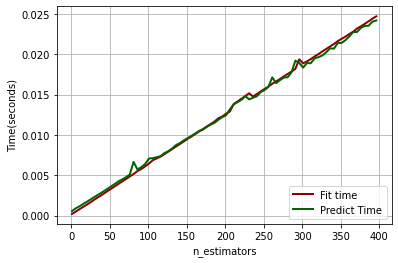

In [74]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]

lw = 2
param_list = params
plt.plot(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)

plt.xlabel('n_estimators')
plt.ylabel("Time(seconds)")
# plt.xticks(np.arange(1, len(param_list), 2.0))
# plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() + '/ada_fit_vs_predict_price.png')

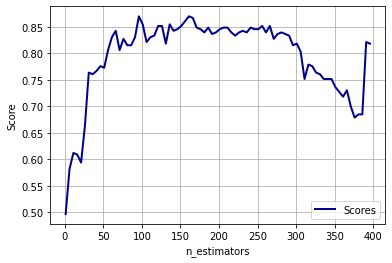

In [73]:
w = 2
plt.plot(param_list, clf_score_list, label="Scores", color="darkblue", lw=lw)
plt.xlabel('n_estimators')
plt.ylabel("Score")
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() + '/ada_estimators_vs_score.png')